In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd
from datetime import datetime
pd.options.display.max_columns = None
from pybaseball import batting_stats, pitching_stats, cache, playerid_lookup, statcast_batter, statcast_pitcher

cache.enable()
cache.config.cache_type='csv'
cache.config.save()

In [2]:
from sqlalchemy import MetaData, text, Column, Integer, String, ForeignKey, Table, create_engine, Float, Boolean, DateTime
from sqlalchemy.orm import relationship, backref, sessionmaker
from sqlalchemy.ext.declarative import declarative_base

meta = MetaData()
engine = create_engine('sqlite:///fantasy_data.db', echo=False)
Session = sessionmaker(bind=engine)
session = Session()
Base = declarative_base()

In [190]:
n_teams = 12
tm_players = 23
tm_dollars = 260
player_split = .6
pitcher_split = 1 - player_split
tot_dollars = n_teams * tm_dollars
tot_players = n_teams * tm_players
tot_hitters = n_teams * 14
tot_pitchers = n_teams * 9

drafted_by_pos = {
    'C':12,
    '1B':18,
    '2B':18,
    '3B':18,
    'SS':18,
    'OF':5*12,
    'MI':12,
    'CI':12,
    'DH':12*2, 
    'P':12*9,
    'SP':12*6.5,
    'RP':12*2.5,
}

def load_data():
    atc = pd.read_csv('data/2022-atc-proj-h.csv')
    dc = pd.read_csv('data/2022-dc-proj-h.csv')
    steamer = pd.read_csv('data/2022-steamer-proj-h.csv')
    val_h = pd.read_csv('data/2022-fangraphs-auction-calculator-h.csv')
    val_h.rename(columns={'PlayerId':'playerid', 'POS':'Pos'},inplace=True)
    h = atc.append(dc).append(steamer).sort_values('playerid')
    h = h.merge(val_h[['playerid', 'Pos', 'Dollars']])
    h.drop(columns=['wOBA', 'CS', 'Fld', 'BsR', 'ADP'],inplace=True)
    h['Primary_Pos'] = h.apply(lambda x: find_primary_pos(x['Pos']), axis=1)
    proj = pd.pivot_table(h, index='playerid', values=['G', 'PA', 'AB', 'H', 'HR', 'R', 'RBI', 'SB'], aggfunc='mean').merge(h[['playerid', 'Name', 'Team', 'Pos', 'Primary_Pos', 'Dollars']], on='playerid', how='inner').drop_duplicates()
    proj['sorter'] = proj['HR']+proj['R']+proj['RBI']+proj['H']+proj['SB']
    proj['BA'] = proj['H']/proj['AB']

    atc = pd.read_csv('data/2022-atc-proj-p.csv')
    dc = pd.read_csv('data/2022-dc-proj-p.csv')
    steamer = pd.read_csv('data/2022-steamer-proj-p.csv')
    val_p = pd.read_csv('data/2022-fangraphs-auction-calculator-p.csv')
    val_p.rename(columns={'PlayerId':'playerid', 'POS':'Pos'},inplace=True)
    p = atc.append(dc).append(steamer).sort_values('playerid')
    p = p.merge(val_p[['playerid', 'Pos', 'Dollars']])
    p.rename(columns={'H':'HA'},inplace=True)
    p['Sv+Hld'] = p['SV']+p['HLD']
    p['Primary_Pos'] = p['Pos'].apply(lambda x: ', '.join(x.split('/')))

    pproj = pd.pivot_table(p, index='playerid', values=['GS', 'G', 'IP', 'ER', 'HA', 'SO', 'BB', 'W', 'SV', 'HLD', 'Sv+Hld'], aggfunc='mean').merge(p[['playerid', 'Name', 'Team', 'Pos', 'Dollars']], on='playerid', how='inner').drop_duplicates()
    pproj['sorter'] = pproj['SO']+(pproj['Sv+Hld']*4)+pproj['W']
    pproj['Primary_Pos'] = pproj.apply(lambda x: find_primary_pos(x['Pos']), axis=1)
    #proj = proj.append(pproj)
    pproj['IP'].fillna(0, inplace=True)
    for i in ['PA', 'AB', 'G', 'H', 'HR', 'R', 'RBI', 'SB']:
        proj[i].fillna(0,inplace=True)
        proj[i] = proj[i].apply(lambda x: int(x))
    for i in ['GS', 'G', 'HA', 'SO', 'ER', 'BB', 'W', 'SV', 'HLD', 'Sv+Hld']:
        pproj[i].fillna(0,inplace=True)
        pproj[i] = pproj[i].apply(lambda x: int(x))
    pproj['ERA'] = pproj['ER']/pproj['IP']*9
    pproj['WHIP'] = (pproj['HA']+pproj['BB'])/pproj['IP']
    return proj.sort_values('Dollars', ascending=False), pproj.sort_values('Dollars', ascending=False)

def calc_z(x, stat):
    z = (x - drafted[stat].mean()) / drafted[stat].std()
    return z

def find_primary_pos(p):
    pos_list = p.split('/')
    pos_hierarchy = ['C', '3B', '2B', '1B', 'SS', 'OF', 'DH', 'SP', 'RP', 'P']
    for i in pos_hierarchy:
        if i in pos_list:
            return i

def check_roster_pos(roster, name, team_name, pos, eligible):
    eligible_at = eligible.split('/')
    eligibility = []
    for p in eligible.split('/'):
        if p=='C':
            eligibility.extend(['C'])
        if p=='1B':
            eligibility.extend(['1B', 'CI'])
        if p=='2B':
            eligibility.extend(['2B', 'MI'])
        if p=='3B':
            eligibility.extend(['3B', 'CI'])
        if p=='SS':
            eligibility.extend(['SS', 'MI'])
        if p=='OF':
            eligibility.extend(['OF1', 'OF2', 'OF3', 'OF4', 'OF5'])
        if p in ['SP', 'RP']:
            eligibility.extend(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9'])
        
    eligibility = list(dict.fromkeys(eligibility))
    if 'SP' in eligible_at or 'RP' in eligible_at: 
        pos_list = eligibility
    else:
        pos_list = eligibility+['DH1', 'DH2']
    for p in pos_list:
        if roster.loc[p, team_name]==0:
            roster.loc[p, team_name] = name
            return p
    
    return pos_list

def next_closest_in_tier(df, pos, playerid):
    try:
        i = df[(df['Primary_Pos']==pos) & (df['playerid']==playerid) & (df['Owner'].isna())].index[0]
        val = df[(df['Primary_Pos']==pos) & (df['Owner'].isna()) & (df['playerid']==playerid)]['Value'].iloc[0]
        return df[df['playerid']==playerid]['Value'].iloc[0] - df[(df['Primary_Pos']==pos) & (df['Owner'].isna()) & (df['Value']<=val)].iloc[1]['Value']
    except:
        return 0
    
def big_board(row, stat):
    # qual_avgs comes from 2019 and 2021 qualified players' averages and stdevs for each stat
    qual_avgs = {'G':[145.0, 10.8], 'PA':[600.4, 59.6], 'AB':[533.4, 53.6], 'H':[143.7, 22.5], 'HR':[24.4, 10.4], 'zlgBA':[0.20, 13.9],
            'R':[82.5, 17.6], 'RBI':[78.9, 19.9], 'SB':[8.6, 8.8], 'AVG':[.269, .026], 'W':[6.1, 4.3], 'GS':[7.6, 13.5], 'Sv+Hld':[12.9, 11.6],
            'ER':[37.3, 23.7], 'IP':[91.2, 53.2], 'SO':[95.7, 57.4], 'BB':[30.2, 15.7], 'HA':[79.7, 50.9], 'zlgERA':[.1235, 89.55], 'zlgWHIP':[-.1512, 17.63368]}
    if stat == 'BA':
        ba_pts = row['H']-(row['AB']*(qual_avgs['H'][0]/qual_avgs['AB'][0]))
        zBA = (ba_pts-qual_avgs['zlgBA'][0])/qual_avgs['zlgBA'][1]
        #return ((row['AB'] * (((row['H']/row['AB'])-qual_avgs['AVG'][0])/qual_avgs['AVG'][1])) - qual_avgs['zlgBA'][0])/qual_avgs['zlgBA'][1]
        return zBA
    elif stat=='ERA':
        pts = ((row['ER']*9) - ((row['IP']*qual_avgs['ER'][0]*9)/qual_avgs['IP'][0])) * -1
        zERA = (pts-qual_avgs['zlgERA'][0])/qual_avgs['zlgERA'][1]
        return zERA
    elif stat=='WHIP':
        pts = ((row['HA']+row['BB'])-(row['IP']*((qual_avgs['HA'][0]+qual_avgs['BB'][0])/qual_avgs['IP'][0]))) * -1
        zWHIP = (pts-qual_avgs['zlgWHIP'][0])/qual_avgs['zlgWHIP'][1]
        return zWHIP
    else:
        return (row[stat] - qual_avgs[stat][0]) / qual_avgs[stat][1]

In [4]:
h, p = load_data()

In [5]:
h['zR'] = h.apply(lambda row: big_board(row, 'R'), axis=1)
h['zHR'] = h.apply(lambda row: big_board(row, 'HR'), axis=1)
h['zRBI'] = h.apply(lambda row: big_board(row, 'RBI'), axis=1)
h['zSB'] = h.apply(lambda row: big_board(row, 'SB'), axis=1)
h['zBA'] = h.apply(lambda row: big_board(row, 'BA'), axis=1)
h['BIGAA'] = h['zR']+h['zRBI']+h['zHR']+h['zSB']+h['zBA']

p['zSO'] = p.apply(lambda row: big_board(row, 'SO'), axis=1)
p['zW'] = p.apply(lambda row: big_board(row, 'W'), axis=1)
p['zSv+Hld'] = p.apply(lambda row: big_board(row, 'Sv+Hld'), axis=1)
p['zERA'] = p.apply(lambda row: big_board(row, 'ERA'), axis=1)
p['zWHIP'] = p.apply(lambda row: big_board(row, 'WHIP'), axis=1)
p['BIGAA'] = p['zSv+Hld']+p['zSO']+p['zW']+p['zERA']+p['zWHIP']

print('Positional adjustment applied by primary position')
c_adjust = abs(h[h['Primary_Pos']=='C'].sort_values('BIGAA',ascending=False).iloc[13]['BIGAA'])
h.loc[h['Primary_Pos']=='C', 'Pos_adj'] = c_adjust
ci_adjust = abs(h[h['Primary_Pos'].isin(['1B', '3B'])].sort_values('BIGAA',ascending=False).iloc[37]['BIGAA'])
h.loc[h['Primary_Pos'].isin(['1B', '3B']), 'Pos_adj'] = ci_adjust
mi_adjust = abs(h[h['Primary_Pos'].isin(['2B', 'SS'])].sort_values('BIGAA',ascending=False).iloc[37]['BIGAA'])
h.loc[h['Primary_Pos'].isin(['2B', 'SS']), 'Pos_adj'] = mi_adjust
of_adjust = abs(h[h['Primary_Pos'].isin(['OF', 'DH'])].sort_values('BIGAA',ascending=False).iloc[61]['BIGAA'])
h.loc[h['Primary_Pos'].isin(['OF', 'DH']), 'Pos_adj'] = of_adjust

print('C',h[h['Primary_Pos']=='C'].sort_values('BIGAA',ascending=False).iloc[13]['BIGAA'])
print('MI',h[h['Primary_Pos'].isin(['2B', 'SS'])].sort_values('BIGAA',ascending=False).iloc[37]['BIGAA'])
print('CI',h[h['Primary_Pos'].isin(['1B', '3B'])].sort_values('BIGAA',ascending=False).iloc[37]['BIGAA'])
print('OF',h[h['Primary_Pos'].isin(['OF', 'DH'])].sort_values('BIGAA',ascending=False).iloc[61]['BIGAA'])

sp_adjust = abs(p[p['Primary_Pos']=='SP'].sort_values('BIGAA',ascending=False).iloc[78]['BIGAA'])
p.loc[p['Primary_Pos']=='SP', 'Pos_adj'] = sp_adjust
rp_adjust = abs(p[p['Primary_Pos']=='RP'].sort_values('BIGAA',ascending=False).iloc[30]['BIGAA'])
p.loc[p['Primary_Pos']=='RP', 'Pos_adj'] = rp_adjust
print('SP',p[p['Primary_Pos'].isin(['SP'])].sort_values('BIGAA',ascending=False).iloc[78]['BIGAA'])
print('RP',p[p['Primary_Pos'].isin(['RP'])].sort_values('BIGAA',ascending=False).iloc[30]['BIGAA'])

# Apply Positional adjustment
h['z'] = h['BIGAA'] + h['Pos_adj']
p['z'] = p['BIGAA'] + p['Pos_adj']

# Apply H/P split
# Commented out the split conversion because the dollar converter works this in by using total dollar / total z of both hitters and pitchers
#p['z'] = p['BIGAA']*(p[p['BIGAA']>0]['BIGAA'].sum()/(h[h['BIGAA']>0]['BIGAA'].sum()+p[p['BIGAA']>0]['BIGAA'].sum()))
#h['z'] = h['BIGAA']*(h[h['BIGAA']>0]['BIGAA'].sum()/(h[h['BIGAA']>0]['BIGAA'].sum()+p[p['BIGAA']>0]['BIGAA'].sum()))
#p['z'] = p['BIGAA']# * pitcher_split
#h['z'] = h['BIGAA']# * player_split

conv = (tm_dollars/tm_players)*(tot_players/(h[h['z']>0]['z'].sum()+p[p['z']>0]['z'].sum()))
print('\nTotal z:',h[h['z']>0]['z'].sum()+p[p['z']>0]['z'].sum())
print('\nH/P split:',h[h['z']>0]['z'].sum()/(h[h['z']>0]['z'].sum()+p[p['z']>0]['z'].sum()))
print('Conversion to $:',conv)

h['Value'] = h['z']*conv
p['Value'] = p['z']*conv

p.loc[p['Name']=='Shohei Ohtani', 'playerid'] = 'p19755'

b = h.append(p)
b['Outs'] = b['IP']*3
b['K/9'] = b['SO']*9/(b['Outs']/3)
b['Timestamp'] = None
b['Paid'] = 0
b['Owner'] = None
b['Used'] = None

#b.loc[b['Name']=='Fernando Tatis Jr.', 'Owner'] = 'Lima Time'
#b.loc[b['Name']=='Fernando Tatis Jr.', 'Paid'] = 36
#b.loc[b['Name']=='Fernando Tatis Jr.', 'Timestamp'] = datetime.now()

Positional adjustment applied by primary position
C -5.862474643007073
MI -3.196632956861173
CI -1.7485226648701246
OF -3.3351378850675966
SP -1.7459132766717516
RP -0.29847867246306425

Total z: 621.8989553378836

H/P split: 0.6524060504154386
Conversion to $: 5.016892170698171


In [49]:
# Uploads data to table
#b.set_index('playerid')[['Name', 'Team', 'Pos', 'Primary_Pos', 'G', 'GS', 'PA', 'AB', 'H', 'HR', 'R', 'RBI', 'SB', 'BA', 'IP', 'Outs', 'HA', 'BB', 'ER', 'W', 'SO', 'Sv+Hld', 'ERA', 'WHIP', 'K/9', 'Dollars', 'z', 'Value', 'Paid', 'Owner', 'Used', 'Timestamp', 'zBA', 'zHR', 'zR', 'zRBI', 'zSB', 'zERA', 'zWHIP', 'zW', 'zSO', 'zSv+Hld']].to_sql('players', engine, if_exists='replace')

In [6]:
def owners():
    df = pd.read_sql('players', engine)
    owners_df = df.groupby('Owner').agg({'Name':'count', 'Paid':'sum', 'z':'sum', 'H':'sum', 'AB':'sum', 'HR':'sum', 'R':'sum', 'RBI':'sum', 'SB':'sum', 'W':'sum', 'Sv+Hld':'sum', 'SO':'sum'}).reset_index()
    owners_df.rename(columns={'Name':'Drafted'},inplace=True)
    owners_df['$/unit'] = owners_df['Paid']/owners_df['z']
    owners_df['$ Left'] = tm_dollars - owners_df['Paid']
    owners_df['$ Left / Plyr'] = owners_df['$ Left'] / (tm_players -owners_df['Drafted'])
    owners_df['BA'] = owners_df['H']/owners_df['AB']
    owners_df['Pts'] = 0
    for i in ['BA', 'HR', 'R', 'RBI', 'SB', 'W', 'Sv+Hld', 'SO']:
        owners_df['Pts'] += owners_df[i].rank()
    owners_df['Rank'] = owners_df['Pts'].rank()
    return df.sort_values('z', ascending=False), owners_df

In [129]:
df, owners_df = owners()
owners_df

,Owner,Drafted,Paid,z,H,AB,HR,R,RBI,SB,W,Sv+Hld,SO,$/unit,$ Left,$ Left / Plyr,BA,Pts,Rank
0,Avg Joes,5,141,29.572630,586.0,2152.0,129.0,368.0,377.0,49.0,13.0,0.0,207.0,4.767922,119,6.611111,0.272305,60.5,9.5
1,Brewbirds,5,134,23.420286,610.0,2180.0,115.0,370.0,363.0,38.0,13.0,0.0,202.0,5.721536,126,7.000000,0.279817,59.5,8.0
2,Charmer,5,134,29.007400,476.0,1705.0,90.0,283.0,269.0,47.0,15.0,32.0,313.0,4.619511,126,7.000000,0.279179,63.0,12.0
3,Dirty Birds,5,113,20.809451,456.0,1671.0,87.0,260.0,268.0,24.0,23.0,0.0,409.0,5.430225,147,8.166667,0.272890,48.0,4.5
4,Harvey,5,112,24.735892,628.0,2281.0,131.0,369.0,396.0,23.0,13.0,0.0,234.0,4.527833,148,8.222222,0.275318,60.5,9.5
5,Lil Trump,5,138,30.251644,592.0,2176.0,128.0,370.0,378.0,29.0,14.0,0.0,259.0,4.561735,122,6.777778,0.272059,62.0,11.0
6,Lima Time,5,82,22.539234,452.0,1636.0,87.0,277.0,252.0,38.0,21.0,0.0,358.0,3.638101,178,9.888889,0.276284,52.5,7.0
7,Midnight,5,114,21.985278,287.0,1062.0,70.0,190.0,183.0,35.0,27.0,33.0,439.0,5.185288,146,8.111111,0.270245,51.0,6.0
8,Moms Cookin,5,95,17.715986,557.0,2119.0,126.0,359.0,349.0,17.0,11.0,0.0,208.0,5.362389,165,9.166667,0.262860,38.0,1.0
9,Roid Ragers,5,115,23.361938,616.0,2289.0,124.0,378.0,382.0,25.0,11.0,0.0,192.0,4.922537,145,8.055556,0.269113,48.0,4.5


In [130]:
owner_list = ['Avg Joes', 'Brewbirds', 'Charmer', 'Dirty Birds', 'Harvey', 'Lil Trump', 'Lima Time', 'Midnight', 'Moms Cookin', 'Roid Ragers', 'Trouble', 'Wu-Tang']
roster = pd.DataFrame(index=['C', '1B', '2B', '3B', 'SS', 'MI', 'CI', 'OF1', 'OF2', 'OF3', 'OF4', 'OF5', 'DH1', 'DH2', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9'], data=np.zeros((23,12)), columns=owner_list)

In [131]:
def check_roster_pos(roster, name, team_name, pos, eligible):
    eligible_at = eligible.split('/')
    eligibility = []
    for p in eligible.split('/'):
        if p=='C':
            eligibility.extend(['C'])
        if p=='1B':
            eligibility.extend(['1B', 'CI'])
        if p=='2B':
            eligibility.extend(['2B', 'MI'])
        if p=='3B':
            eligibility.extend(['3B', 'CI'])
        if p=='SS':
            eligibility.extend(['SS', 'MI'])
        if p=='OF':
            eligibility.extend(['OF1', 'OF2', 'OF3', 'OF4', 'OF5'])
        if p in ['SP', 'RP']:
            eligibility.extend(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9'])
        
    eligibility = list(dict.fromkeys(eligibility))
    if 'SP' in eligible_at or 'RP' in eligible_at: 
        pos_list = eligibility
    else:
        pos_list = eligibility+['DH1', 'DH2']
    for p in pos_list:
        if roster.loc[p, team_name]==0:
            roster.loc[p, team_name] = name
            return p
    
    return pos_list

In [132]:
owner_list = ['Avg Joes', 'Brewbirds', 'Charmer', 'Dirty Birds', 'Harvey', 'Lil Trump', 'Lima Time', 'Midnight', 'Moms Cookin', 'Roid Ragers', 'Trouble', 'Wu-Tang']
roster = pd.DataFrame(index=['C', '1B', '2B', '3B', 'SS', 'MI', 'CI', 'OF1', 'OF2', 'OF3', 'OF4', 'OF5', 'DH1', 'DH2', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9'], data=np.zeros((23,12)), columns=owner_list)
for tm in owners_df.Owner.to_list():
    for i, row in df[df['Owner']==tm][['Name', 'Owner', 'Primary_Pos', 'Pos', 'Timestamp']].sort_values("Timestamp").iterrows():
        check_roster_pos(roster, df.loc[i]['Name'], df.loc[i]['Owner'], df.loc[i]['Primary_Pos'], df.loc[i]['Pos'])

In [133]:
roster

,Avg Joes,Brewbirds,Charmer,Dirty Birds,Harvey,Lil Trump,Lima Time,Midnight,Moms Cookin,Roid Ragers,Trouble,Wu-Tang
C,Will Smith,0,0,0,0,Salvador Perez,0,0,0,0,J.T. Realmuto,Omar Narvaez
1B,0,Jared Walsh,0,0,Vladimir Guerrero Jr.,0,0,0,Matt Olson,Pete Alonso,0,0
2B,0,Trea Turner,0,0,0,Ozzie Albies,Marcus Semien,0,0,Mookie Betts,0,0
3B,Jose Ramirez,0,0,Rafael Devers,Austin Riley,Josh Donaldson,0,0,0,0,0,0
SS,Bo Bichette,Corey Seager,Tim Anderson,0,0,0,Fernando Tatis Jr.,0,0,Xander Bogaerts,Trevor Story,Carlos Correa
MI,0,0,0,0,0,0,0,0,0,0,0,0
CI,0,0,0,0,Jose Abreu,0,0,0,Anthony Rizzo,0,0,0
OF1,Aaron Judge,Mike Trout,Kyle Tucker,Alex Verdugo,Randy Arozarena,Juan Soto,Michael Brantley,Ronald Acuna Jr.,Jesse Winker,J.D. Martinez,Adam Duvall,Shohei Ohtani
OF2,0,0,Bryce Harper,Tyler O'Neill,0,0,0,Teoscar Hernandez,George Springer,0,Starling Marte,0
OF3,0,0,0,0,0,0,0,0,0,0,0,0


In [134]:
print('# of Players Yet to be Drafted:',(n_teams*tot_players) - owners_df.Drafted.sum())
print('$ still available to be spent:', tot_dollars - owners_df.Paid.sum())
print('Initial $ per z rate:',tot_dollars/df[df['z']>=0]['z'].sum())
print('Current $ per z rate:',owners_df.Paid.sum() / owners_df.z.sum())
conv_factor = (tot_dollars - owners_df.Paid.sum()) / (df[df['z']>0]['z'].sum()-owners_df['z'].sum())
print('Conversion Factor:',conv_factor)

# of Players Yet to be Drafted: 3252
$ still available to be spent: 1755
Initial $ per z rate: 5.01689217069817
Current $ per z rate: 4.825173346222707
Conversion Factor: 5.176875636148047


In [135]:
df['adjValue'] = df['z'] * conv_factor

In [136]:
df[['Name', 'z', 'Paid', 'Owner', 'Value', 'adjValue', 'Dollars']].head()

,Name,z,Paid,Owner,Value,adjValue,Dollars
0,Fernando Tatis Jr.,10.467208,36,Lima Time,52.512856,54.187436,40.784208
2,Juan Soto,9.390390,40,Lil Trump,47.110573,48.612880,37.932103
10,Ronald Acuna Jr.,8.211041,41,Midnight,41.193905,42.507536,26.025719
628,Jacob deGrom,8.188986,35,Charmer,41.083261,42.393363,41.513278
1,Vladimir Guerrero Jr.,8.064958,23,Harvey,40.461024,41.751283,40.252202


In [137]:
def set_color(x):
    if(x == None):
        return "blue"
    else:
        return "gray"

        
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df['Name'].head(276),
        y=df['z'].head(276),
        mode='markers',
        marker=dict(color=list(map(set_color,df['Owner'])))
    )
)
fig.show()

In [138]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=b['Primary_Pos'],
        y=b.query('z>=0')['z'],
        text=b['Name'],
        mode='markers',
    )
)

#### Next Closest in Tier

In [139]:
tier_pos = df[df['Name']=='Freddie Freeman']['Primary_Pos'].iloc[0]
drop_in_tier = round(df[(df['Primary_Pos']==tier_pos) & (df['Owner'].isna())].iloc[1]['Value'] - df[(df['Primary_Pos']==tier_pos) & (df['Owner'].isna())].iloc[0]['Value'],1)
print(drop_in_tier)
df[(df['Primary_Pos']==tier_pos) & (df['Owner'].isna())].iloc[:6][['Name', 'Pos', 'z', 'Value', 'HR', 'SB', 'RBI', 'R', 'BA']]

-5.9


,Name,Pos,z,Value,HR,SB,RBI,R,BA
11,Freddie Freeman,1B,4.859708,24.380631,30.0,6.0,95.0,103.0,0.292442
24,Paul Goldschmidt,1B,3.683766,18.481057,30.0,7.0,90.0,97.0,0.275586
50,Josh Bell,1B/OF/DH,2.077314,10.421661,30.0,0.0,97.0,85.0,0.262315
51,Ryan Mountcastle,1B/OF/DH,1.411211,7.079895,30.0,4.0,87.0,77.0,0.259390
58,C.J. Cron,1B,1.406112,7.054310,29.0,1.0,89.0,76.0,0.267965
67,Joey Votto,1B,1.347745,6.761493,30.0,1.0,89.0,86.0,0.249225


In [176]:
i = df[(df['Primary_Pos']=='SS') & (df['playerid']=='18314') & (df['Owner'].isna())].index[0]
v = df[(df['Primary_Pos']=='SS') & (df['Owner'].isna()) & (df['playerid']=='18314')]['Value'].iloc[0]
df[(df['Primary_Pos']=='SS') & (df['Owner'].isna()) & (df['Value']<=v)].iloc[1]['Value']

8.604983664708165

In [188]:
df['next_in_tier'] = df.apply(lambda x: next_closest_in_tier(df, x['Primary_Pos'], x['playerid']),axis=1)

<AxesSubplot:>

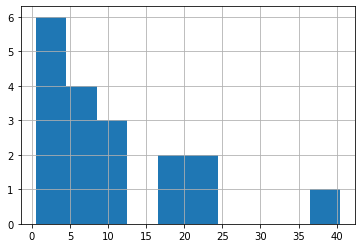

In [21]:
df[(df['Primary_Pos']==tier_pos) & (df['z']>0)]['Value'].hist()

## ------ End of New Work

In [ ]:
def process_top_hitters():
    # Define two empty dicts
    pos_avg = {}
    pos_std = {}
    # Create Used field and set to False, for tracking which players are considered drafted
    h['Used'] = False
    # For each of these positions, define a mask to isolate the unused players who are eligible at that position
    for position in ['C', '2B', '1B', 'OF', '3B', 'SS']:
        mask = (h['Pos'].str.contains(position)) & (h['Used']==False)
        pos_avg[position], pos_std[position] = {}, {}
        
        # Rate stats first
        # Calculate the BA Z score. Because it is a rate, it takes a different formula: H - (AB * (lgH/lgAB))
        pos_index_list = h[mask].index[:drafted_by_pos[position]]
        h.loc[pos_index_list, 'BA'] = (h[mask]['H'] - (h[mask]['AB'] * (h[mask]['H'].sum()/h[mask]['AB'].sum())))
        
        # For each stat category, fill in the dictionaries with an average and standard deviation using the top N players
        # where N is established by the number of drafted players at that position by the league (eg 1B = 12, OF=60)
        for stat in ['PA', 'AB', 'BA', 'HR', 'RBI', 'R', 'SB']:
            pos_avg[position][stat] = round(h.loc[h[mask].index[:drafted_by_pos[position]], stat].mean(),1)
            pos_std[position][stat] = round(h.loc[h[mask].index[:drafted_by_pos[position]], stat].std(),1)
            # Using the player's stat projection, calculate their Z score among the top players
            for j in h[mask].index[:drafted_by_pos[position]]:
                h.loc[j, 'z'+stat] = (h.loc[j][stat] - pos_avg[position][stat]) / pos_std[position][stat]
        
        # Sum the 5 stat category Z scores
        h.loc[h[mask].index[:drafted_by_pos[position]], 'z'] = h['zR'] + h['zRBI'] + h['zHR'] + h['zBA'] + h['zSB']
        # Make the last player's Z score equal 0, then adjust the rest by that same amount
        if h.loc[h[mask].index[:drafted_by_pos[position]]].sort_values('z')['z'].iloc[0] < 0:
            h.loc[h[mask].index[:drafted_by_pos[position]], 'z'] += abs(h.loc[h[mask].index[:drafted_by_pos[position]]].sort_values('z')['z'].iloc[0])
        else:
            h.loc[h[mask].index[:drafted_by_pos[position]], 'z'] -= h.loc[h[mask].index[:drafted_by_pos[position]]].sort_values('z')['z'].iloc[0]
        # Assign the current position as the player's Primary_Pos
        h.loc[h[mask].index[:drafted_by_pos[position]], 'Primary_Pos'] = position
        #print(position+':\n',h.loc[h[mask].index[:drafted_by_pos[position]]]['Name'].unique())
        # Mark these players as Used so they do not get used in another position
        h.loc[h[mask].index[:drafted_by_pos[position]], 'Used'] = True

    # This is the same process as above except it does it for the MI and CI categories which means you have to find the 
    # top 12 middle/corner infielders available
    for position in ['MI', 'CI']:
        if position == 'MI':
            pos_avg[position], pos_std[position] = {}, {}
            mask = ((h['Pos'].str.contains('SS')) & (h['Used']==False)) | ((h['Pos'].str.contains('2B')) & (h['Used']==False))
            
            pos_index_list = h[mask].index[:drafted_by_pos[position]]
            h.loc[pos_index_list, 'BA'] = (h[mask]['H'] - (h[mask]['AB'] * (h[mask]['H'].sum()/h[mask]['AB'].sum())))
        
            for stat in ['PA', 'AB', 'BA', 'HR', 'RBI', 'R', 'SB']:
                pos_avg[position][stat] = round(h.loc[h[mask].index[:drafted_by_pos[position]], stat].mean(),1)
                pos_std[position][stat] = round(h.loc[h[mask].index[:drafted_by_pos[position]], stat].std(),1)
                for j in h[mask].index[:drafted_by_pos[position]]:
                    h.loc[j, 'z'+stat] = (h.loc[j][stat] - pos_avg[position][stat]) / pos_std[position][stat]

            h.loc[h[mask].index[:drafted_by_pos[position]], 'z'] = h['zR'] + h['zRBI'] + h['zHR'] + h['zBA'] + h['zSB']
            h.loc[h[mask].index[:drafted_by_pos[position]], 'z'] += abs(h.loc[h[mask].index[:drafted_by_pos[position]]].sort_values('z')['z'].iloc[0])
            h.loc[h[mask].index[:drafted_by_pos[position]], 'Primary_Pos'] = position
            #print(position+':\n',h.loc[h[mask].index[:12]]['Name'].unique())
            h.loc[h[mask].index[:drafted_by_pos[position]], 'Used'] = True

        elif position == 'CI':
            pos_avg[position], pos_std[position] = {}, {}
            mask = ((h['Pos'].str.contains('1B')) & (h['Used']==False)) | ((h['Pos'].str.contains('3B')) & (h['Used']==False))
            
            pos_index_list = h[mask].index[:drafted_by_pos[position]]
            h.loc[pos_index_list, 'BA'] = (h[mask]['H'] - (h[mask]['AB'] * (h[mask]['H'].sum()/h[mask]['AB'].sum())))
            
            for stat in ['PA', 'AB', 'BA', 'HR', 'RBI', 'R', 'SB']:
                pos_avg[position][stat] = round(h.loc[h[mask].index[:drafted_by_pos[position]], stat].mean(),1)
                pos_std[position][stat] = round(h.loc[h[mask].index[:drafted_by_pos[position]], stat].std(),1)
                for j in h[mask].index[:drafted_by_pos[position]]:
                    h.loc[j, 'z'+stat] = (h.loc[j][stat] - pos_avg[position][stat]) / pos_std[position][stat]

            h.loc[h[mask].index[:drafted_by_pos[position]], 'z'] = h['zR'] + h['zRBI'] + h['zHR'] + h['zBA'] + h['zSB']
            h.loc[h[mask].index[:drafted_by_pos[position]], 'z'] += abs(h.loc[h[mask].index[:drafted_by_pos[position]]].sort_values('z')['z'].iloc[0])
            h.loc[h[mask].index[:drafted_by_pos[position]], 'Primary_Pos'] = position
            #print(position+':\n',h.loc[h[mask].index[:12]]['Name'].unique())
            h.loc[h[mask].index[:drafted_by_pos[position]], 'Used'] = True

    # Same process again but uses all remaining hitters and takes the top 12. Expect to see the true DHs at the top
    pos_avg['DH'], pos_std['DH'] = {}, {}
    mask = (h['Used']==False)
    
    pos_index_list = h[mask].index[:drafted_by_pos[position]]
    h.loc[pos_index_list, 'BA'] = (h[mask]['H'] - (h[mask]['AB'] * (h[mask]['H'].sum()/h[mask]['AB'].sum())))
        
    for stat in ['PA', 'AB', 'BA', 'HR', 'RBI', 'R', 'SB']:
        pos_avg['DH'][stat] = round(h.loc[h[mask].index[:24], stat].mean(),1)
        pos_std['DH'][stat] = round(h.loc[h[mask].index[:24], stat].std(),1)
        for j in h[mask].index[:24]:
                h.loc[j, 'z'+stat] = (h.loc[j][stat] - pos_avg['DH'][stat]) / pos_std['DH'][stat]

    h.loc[h[mask].index[:24], 'z'] = h['zR'] + h['zRBI'] + h['zHR'] + h['zBA'] + h['zSB']
    h.loc[h[mask].index[:24], 'z'] += abs(h.loc[h[mask].index[:24]].sort_values('z')['z'].iloc[0])
    h.loc[h[mask].index[:24], 'Primary_Pos'] = 'DH'
    #print('DH:\n',h.loc[h[mask].index[:24]]['Name'].unique())
    #print('DH:\n',h.loc[h[mask].index[:24]].index)
    sub_mask = h.loc[h[mask].index[:24]].index
    h.loc[h[mask].index[:24], 'Used'] = True
    
    if len(h[h['Used']==True])!=14*num_teams:
        print('drafted list not right')
    return pos_avg, pos_std


In [ ]:
def process_rem_hitters(pos_avg, pos_std):
    for position in ['C', '2B', '1B', 'OF', '3B', 'SS']:
        mask = (h['Used']==False) & (h['Primary_Pos']==position)
        h.loc[mask, 'BA'] = (h[mask]['H'] - (h[mask]['AB'] * (h[(h['Used']==True) & (h['Primary_Pos']==position)]['H'].sum()/h[(h['Used']==True) & (h['Primary_Pos']==position)]['AB'].sum())))
        for stat in ['PA', 'AB', 'BA', 'HR', 'RBI', 'R', 'SB']:
            h.loc[mask, 'z'+stat] = (h[stat] - pos_avg[position][stat]) / pos_std[position][stat]

    h.loc[h['Used']==False, 'z'] = h['zBA'] + h['zHR'] + h['zRBI'] + h['zR'] + h['zSB']
    return

In [ ]:
def process_pitchers():
    #(p['ER']*9) - (p['IP'] * ((lgERsum * 9)/(lgIPsum))) * -1
    p['xER'] = ((p['ER']*9) - (p['IP'] * (p['ER'].iloc[:108].sum()*9)/p['IP'].iloc[:108].sum())) * -1
    p['xWHIP'] = ((p['H']+p['BB']) - (p['IP'] * ((p['H'].iloc[:108].sum()+p['BB'].iloc[:108].sum()) / p['IP'].iloc[:108].sum()))) * -1
    p_avg = p.iloc[:108][['W', 'SO', 'Sv+Hld', 'xER', 'xWHIP']].mean()
    p_std = p.iloc[:108][['W', 'SO', 'Sv+Hld', 'xER', 'xWHIP']].std()
    for i in ['W', 'SO', 'Sv+Hld', 'xER', 'xWHIP']:
        p['z'+i] = p[i].apply(lambda x: (x - p_avg[i]) / p_std[i])
    p['z'] = p['zW'] + p['zSO'] + p['zSv+Hld'] + p['zxER'] + p['zxWHIP']
    p_adjustment_value = abs(p.sort_values('z', ascending=False).iloc[107]['z'])
    p['z'] = p['z'].apply(lambda x: x+p_adjustment_value)
    return

In [ ]:
### Old way ###
h, p = load_data()
h['Primary_Pos'] = h['Pos'].apply(lambda x: find_primary_pos(x))
p['Primary_Pos'] = p['Pos'].apply(lambda x: find_primary_pos(x))
pos_avg, pos_std = process_top_hitters()
process_rem_hitters(pos_avg, pos_std)
tot_z = h[h['Used']==True]['z'].sum()
h['Value'] = (h['z'] / tot_z) * tot_dollars * player_split
h.sort_values('Value', ascending=False).head(10)
h['Owner'] = None
h['Paid'] = None

In [ ]:
#(p['ER']*9) - (p['IP'] * ((lgERsum * 9)/(lgIPsum))) * -1
p['xER'] = ((p['ER']*9) - (p['IP'] * (p['ER'].iloc[:108].sum()*9)/p['IP'].iloc[:108].sum())) * -1

In [ ]:
p['xWHIP'] = ((p['H']+p['BB']) - (p['IP'] * ((p['H'].iloc[:108].sum()+p['BB'].iloc[:108].sum()) / p['IP'].iloc[:108].sum()))) * -1

In [ ]:
p_avg = p.iloc[:108][['W', 'SO', 'Sv+Hld', 'xER', 'xWHIP']].mean()
p_std = p.iloc[:108][['W', 'SO', 'Sv+Hld', 'xER', 'xWHIP']].std()

In [ ]:
for i in ['W', 'SO', 'Sv+Hld', 'xER', 'xWHIP']:
    p['z'+i] = p[i].apply(lambda x: (x - p_avg[i]) / p_std[i])

In [ ]:
p['z'] = p['zW'] + p['zSO'] + p['zSv+Hld'] + p['zxER'] + p['zxWHIP']

In [ ]:
p_adjustment_value = abs(p.sort_values('z', ascending=False).iloc[107]['z'])
p['z'] = p['z'].apply(lambda x: x+p_adjustment_value)

In [ ]:
from sqlalchemy import text
pid = '19611'
price = 38
owner = 'Harvey'
t = text("UPDATE hitting SET Owner='"+owner+"', Paid="+str(price)+" WHERE playerid='"+pid+"'")
result = conn.execute(t)
result

https://leportella.com/sqlalchemy-tutorial/

In [ ]:
#Creates a table on the DB
meta = MetaData()
hitters = Table('hitting', meta,
                Column('playerid', String, primary_key=True),
                #Column('name', String(50)),
                #Column('team', String(20)),
                #Column('pa', Integer),
                #Column('ab', Integer),
                #Column('ba', Float),
                #Column('h', Integer),
                #Column('hr', Integer),
                #Column('r', Integer),
                #Column('rbi', Integer),
                #Column('sb', Integer),
                Column('Paid', Integer),
                Column('Owner', String(25)),
                Column('Used', Boolean)
)
meta.create_all(engine)

In [ ]:
conn = engine.connect()

In [ ]:
#conn.execute(hitters.delete().where(hitters.c.Used==None))

In [ ]:
conn.execute(hitters.update().values(Paid=15, Owner='Harvey').where(hitters.c.playerid=='15172'))
conn.execute(hitters.update().values(Paid=1, Owner='Harvey').where(hitters.c.playerid=='16375'))

In [ ]:
import json
j = h.sort_values('z', ascending=False).to_json(orient='records')
j = json.loads(j)
j

In [34]:
mask = (df['Owner'].isna()) & (df['Primary_Pos']=='OF')
df[mask][['Name', 'z', 'Dollars', 'Pos']].sort_values('z', ascending=False).head(10)

,Name,z,Dollars,Pos
2,Juan Soto,9.390390,37.932103,OF
10,Ronald Acuna Jr.,8.211041,26.025719,OF
9,Bryce Harper,7.248026,27.485023,OF
12,Mike Trout,6.234178,25.942635,OF
16,Yordan Alvarez,6.159642,25.272377,OF/DH
14,Kyle Tucker,6.153412,25.381511,OF
15,Luis Robert,6.083746,25.322911,OF
27,George Springer,5.212707,20.240662,OF/DH
52,Starling Marte,4.995739,14.836125,OF
23,Tyler O'Neill,4.945308,21.173880,OF


In [35]:
single_player = (h['Name']=='Robert Witt')

fig = go.Figure(data=go.Scatterpolar(
  r=h[single_player][['zBA', 'zR', 'zRBI', 'zHR', 'zSB']].values.tolist()[0],
  theta=['zBA', 'zR', 'zRBI', 'zHR', 'zSB'],
  fill='toself',
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    ),
  ),
  showlegend=False
)

fig.show()

In [36]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=owners_df['Owner'],
        y=owners_df['Pts'],
    )
)
fig.show()

In [38]:
fig = px.scatter(
    owners_df, x='$ Left', y='Pts', opacity=0.65,
    trendline='ols', trendline_color_override='darkblue'
)
fig.show()

In [23]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.stats import pearsonr
def scale_data(df, cols):
    """
    INPUT: 
        df: original dataframe
        list: subset of columns to scale
    OUTPUT:
        df: scaled data
    """
    scaler = MinMaxScaler()
    scaler.fit(df[cols])
    scaled_df = scaler.transform(df[cols])
    scaled_df = pd.DataFrame(scaled_df, index=df.index)
    scaled_df.columns=[df[cols].columns.tolist()]
    return scaled_df

In [24]:
cols = ['BA', 'R', 'RBI', 'HR', 'SB']
scaled_df = scale_data(df[df['Owner'].isna()].set_index('playerid'), cols)
scaled_df.loc['11737', cols]

BA     0.814794
R      0.794643
RBI    0.845455
HR     0.707317
SB     0.071429
Name: 11737, dtype: float64

In [25]:
def add_distance_metrics(h, player_id, col_list):
    scaled_df = scale_data(h[h['Owner'].isna()].set_index('playerid'), col_list)
    df2 = h[h['Owner'].isna()].loc[:,['playerid', 'Name', 'Pos', 'z']+col_list].set_index('playerid')
    for j, row in scaled_df.iterrows():
        #df2.at[j,'corr'] = pearsonr(scaled_df.loc[player_id,col_list],row[col_list])[0]
        df2.at[j,'eucl_dist'] = np.linalg.norm(scaled_df.loc[player_id,col_list] - row[col_list])
        #df2.at[j,'manh_dist']= sum(abs(e - s) for s, e in zip(scaled_df.loc[player_id,col_list], row[col_list]))
    return df2.sort_values('eucl_dist').iloc[1:6]

In [29]:
add_distance_metrics(df, '9218', cols)

,Name,Pos,z,BA,R,RBI,HR,SB,eucl_dist
playerid,,,,,,,,,
5361,Freddie Freeman,1B,4.859708,0.292442,103.0,95.0,30.0,6.0,0.089777
11737,Nick Castellanos,OF,4.280219,0.271598,89.0,93.0,29.0,3.0,0.125117
18882,Brandon Lowe,2B/OF,3.450559,0.247494,88.0,87.0,32.0,6.0,0.131340
12856,George Springer,OF/DH,5.212707,0.259904,100.0,88.0,35.0,7.0,0.134661
11493,Manny Machado,3B,4.483346,0.273769,92.0,102.0,32.0,10.0,0.146305


In [ ]:
mask = (df['Pos'].str.contains('C')) & (df['Owner'].isna())
df[mask][['Name', 'z', 'Dollars', 'HR', 'R', 'RBI', 'SB', 'BA']].sort_values('z', ascending=False).head(10)

In [ ]:
# (Tm 1 $/plyr left / Tm 2 $/plyr left) * suggested price = equivalent comfort level
pp = 5
f'If the price is {pp}, Tm 1 can afford to pay up to {round((10.125 / 6.9) * pp,1)} at the same comfort level as Tm 2'

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=b['Dollars'],
    y=b['Value'],
    mode='markers',
    text=b['Name']
)
)
fig.show()

In [ ]:
#Creates a table on the DB
meta = MetaData()
players = Table('players', meta,
                Column('playerid', String, primary_key=True),
                Column('Name', String(50)),
                Column('Team', String(20)),
                Column('Pos', String(30)),
                Column('Primary_Pos', String(10)),
                Column('G', Integer),
                Column('GS', Integer),
                Column('PA', Integer),
                Column('AB', Integer),
                Column('H', Integer),
                Column('HR', Integer),
                Column('R', Integer),
                Column('RBI', Integer),
                Column('SB', Integer),
                Column('BA', Float),
                Column('OBP', Float),
                Column('SLG', Float),
                Column('OPS', Float),
                Column('IP', Float),
                Column('Outs', Integer),
                Column('HA', Integer),
                Column('BB', Integer),
                Column('ER', Integer),
                Column('SV', Integer),
                Column('HLD', Integer),
                Column('Sv+Hld', Integer),
                Column('W', Integer),
                Column('SO', Integer),
                Column('ERA', Float),
                Column('WHIP', Float),
                Column('K/9', Float),
                Column('Dollars', Float),
                Column('z', Float),
                Column('Value', Float),
                Column('Paid', Integer),
                Column('Owner', String(25)),
                Column('Used', Boolean),
                Column('Timestamp', DateTime)
)
meta.create_all(engine)

In [ ]:
conn.execute('ALTER TABLE hitting ADD COLUMN WHIP Float')

In [ ]:
#conn.execute('DROP Table players')

In [ ]:
#conn.execute('ALTER TABLE hitting DROP COLUMN Paid2')

In [ ]:
#conn.execute('ALTER TABLE hitting ADD COLUMN Timestamp DATETIME')

In [ ]:
conn.close()